In [102]:
import torch
import torch.distributions as D
import numpy as np
from generative import GenerativeModel
from ensemble import Ensemble
from particle import print_particle_params

import matplotlib.pyplot as plt

In [105]:
# Standard prior parameters for conjugate models
niw_param = {
    'mu0': torch.tensor([0.0, 0.0, 0.0]),
    'kappa0': 0.1,
    'nu0': 3.0,
    'Lambda0': torch.eye(3) * 10.0
    
}
dir_param = torch.tensor([1.0, 1.0, 1.0, 1.0])

Jump times: [0, 40, 103]


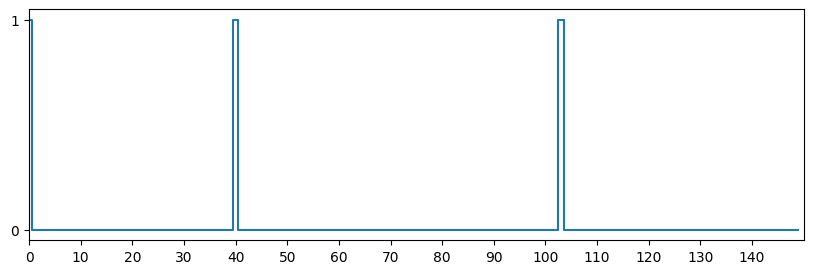

In [112]:
gm = GenerativeModel(hyp_gamma=0.02, hyp_alpha_o = 2.5, hyp_alpha_r=2.5, hyp_obs=niw_param, hyp_rew=dir_param)

T = 150

jumps = gm.sample_jump_times(T)

# get jump times (j==1) as a list (one liner)
jump_times = [t for t in range(0,T) if jumps[t]==1]
print("Jump times:", jump_times)

plt.figure(figsize=(10,3))
plt.plot(jumps, label='Jumps', drawstyle='steps-mid')
plt.xlim(-0.1,T)
plt.xticks(torch.arange(0,T,10))
plt.yticks([0,1])
plt.show()

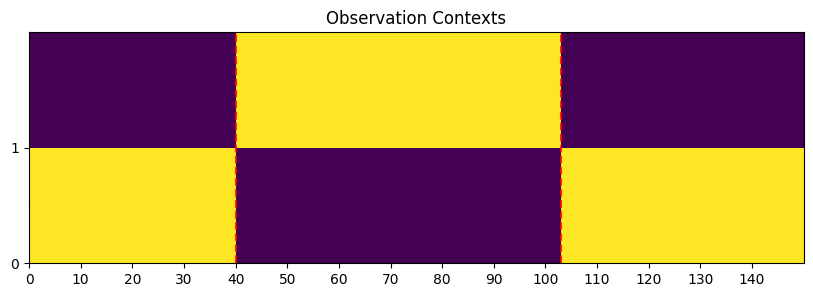

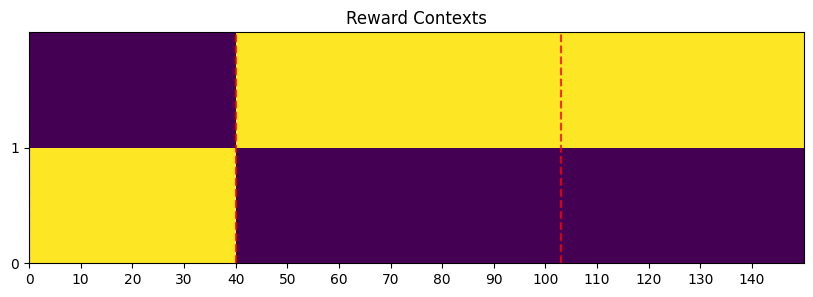

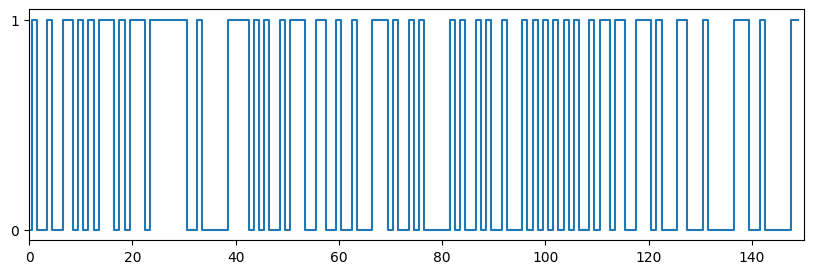

In [113]:

obs_contexts = gm.sample_obs_contexts(jumps)
rew_contexts = gm.sample_rew_contexts(jumps)
states = gm.sample_state(T)

plt.figure(figsize=(10,3))
# make contexts one-hot for plotting
obs_contexts_onehot = torch.zeros((T, max(obs_contexts)+1))
for t in range(T):
    obs_contexts_onehot[t, obs_contexts[t]] = 1.0
img = obs_contexts_onehot.T
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], origin='lower', aspect='auto', cmap='viridis', interpolation='none')
plt.title('Observation Contexts')
plt.yticks(torch.arange(max(obs_contexts)+1))
plt.xticks(torch.arange(0,T,10))
plt.xlim(-0.1,T)
for time in jump_times:
    plt.axvline(x=time, color='red', linestyle='--', alpha=0.8)
plt.show()

plt.figure(figsize=(10,3))
# make contexts one-hot for plotting
rew_contexts_onehot = torch.zeros((T, max(rew_contexts)+1))
for t in range(T):
    rew_contexts_onehot[t, rew_contexts[t]] = 1.0
img = rew_contexts_onehot.T
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], origin='lower', aspect='auto', cmap='viridis', interpolation='none')
plt.title('Reward Contexts')
plt.yticks(torch.arange(max(rew_contexts)+1))
plt.xticks(torch.arange(0,T,10))
plt.xlim(-0.1,T)
for time in jump_times:
    plt.axvline(x=time, color='red', linestyle='--', alpha=0.8)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(states, label='States', drawstyle='steps-mid')
plt.xlim(-0.1,T)
plt.yticks([0,1])
plt.show()


In [161]:
obs_models = gm.sample_observation_models(obs_contexts)
# make sure that all observation covariances are positive, by adding a small value to the diagonal
for s in [0,1]:
    for context, model in enumerate(obs_models[s]):
        model.covariance_matrix += torch.eye(model.covariance_matrix.shape[0]) * 1e-2

rew_models = gm.sample_reward_models(rew_contexts)

print("Observation Models:")
for s in [0,1]:
    for context, model, in enumerate(obs_models[s]):
        print(f"State {s}, Context {context}: Mean {model.mean}, Cov {model.covariance_matrix}")
print("Reward Models:")
for s in [0,1]:
    for context, model in enumerate(rew_models[s]):
        print(f"State {s}, Context {context}: Probabilities {model}")

Observation Models:
State 0, Context 0: Mean tensor([-1.3575, -2.0792,  0.4660]), Cov tensor([[ 0.1059,  0.1097, -0.0065],
        [ 0.1097,  0.3026, -0.0246],
        [-0.0065, -0.0246,  0.0347]])
State 0, Context 1: Mean tensor([0.6258, 0.2133, 1.6487]), Cov tensor([[0.3072, 0.2167, 0.2368],
        [0.2167, 0.1967, 0.1694],
        [0.2368, 0.1694, 0.2715]])
State 1, Context 0: Mean tensor([-0.9511,  0.2677, -2.0841]), Cov tensor([[ 0.0996,  0.0380, -0.0588],
        [ 0.0380,  0.1239, -0.3802],
        [-0.0588, -0.3802,  1.5648]])
State 1, Context 1: Mean tensor([-7.0428,  2.2226,  0.1290]), Cov tensor([[ 1.3827, -0.5160, -0.1315],
        [-0.5160,  0.2328,  0.0611],
        [-0.1315,  0.0611,  0.0566]])
Reward Models:
State 0, Context 0: Probabilities [0.22941384 0.2627107  0.04710644 0.46076903]
State 0, Context 1: Probabilities [0.07986516 0.208993   0.06441008 0.64673173]
State 1, Context 0: Probabilities [0.09431334 0.38250023 0.11632531 0.40686113]
State 1, Context 1: Proba

In [202]:
model = obs_models[0][0]
print(model.mean)
print(model.covariance_matrix)

# check covariance is positive definite
eigenvalues = torch.linalg.eigvals(model.covariance_matrix)
print("Eigenvalues of covariance matrix:", eigenvalues)

obs_models[0][0].sample()


tensor([-1.3575, -2.0792,  0.4660])
tensor([[ 0.1059,  0.1097, -0.0065],
        [ 0.1097,  0.3026, -0.0246],
        [-0.0065, -0.0246,  0.0347]])
Eigenvalues of covariance matrix: tensor([0.3536+0.j, 0.0576+0.j, 0.0320+0.j])


tensor([-2.0917, -3.5283,  0.6057])

In [203]:
obs = gm.sample_observations(states, obs_contexts, obs_models)

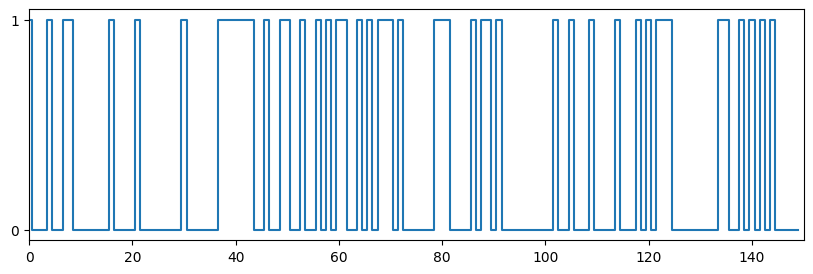

In [204]:
random_actions = np.random.choice([0,1,2,3], size=T)

rewards = gm.sample_rewards(states, rew_contexts, rew_models, random_actions)

plt.figure(figsize=(10,3))
plt.plot(rewards, label='Rewards', drawstyle='steps-mid')
plt.xlim(-0.1,T)
plt.yticks([0,1])
plt.show()